In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError

concept drift detection method DDM with a data stream blocks (concepts)

Four different concepts of 10000 samples each are used. The first one is only used to train a model, while the other two concepts (blocks 3 and 4) are used for testing purposes following a streaming approach, in which the samples are given to the model one at a time.

In [2]:
concept_samples = 10000
generator = SEA(seed=31)
# Generate concepts 1, 3 and 4 without noise
concepts = [generator.generate_dataset(
        block=block, noise=0.0, num_samples=concept_samples,
    ) for block in [1, 3, 4]]

X, y = [], []
for concept in concepts:
    for X_sample, y_sample in concept:
        X.append(X_sample)
        y.append(y_sample)
X, y = np.array(X), np.array(y)

# Split data in reference (concept 1) and test (concepts 3 and 4)
split_idx = concept_samples
X_ref, y_ref, X_test, y_test = X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:].reshape(-1, 1)

A configuration class with the detector parameters is defined. For this particular case, it only contains warning and drift threshold levels and the minimum number of instances to start checking for drift.

In [3]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=100,
)

The detector can be defined by passing the above defined configuration class.

In [4]:
detector = DDM(
    config=config,
)

Fitting a decision tree with the training/reference dataset.

In [5]:
model = DecisionTreeClassifier(random_state=31)
model.fit(X=X_ref, y=y_ref)

DecisionTreeClassifier(random_state=31)

Some metrics to use during the stream simulation can be tracked, in this case we set prequential error with $\alpha = 1.0$ and $\alpha = 0.999$. The former can be seen like an accuracy metric that weights each sample error with the same weight and the latter gives 99,9% weight to the previous samples and the remaining 1% to the new error value.

In [6]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"PR(alpha={alpha})",
    )
    for alpha in [1.0, 0.999]
]

In order to demonstrate the use of the detector, a data stream is simulated by iterating over the test dataset. As this is an example, it is assumed that all ground-truth values are available in a sequential order, but the update method of the detector object could be called on demand and not strictly sequentially assuming you have all the labels.

In [7]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

estimator_name = DecisionTreeClassifier.__name__
detector_name = f"{estimator_name} + {DDM.__name__}"
metrics_historic_detector = {f"{detector_name}; {metric.name}": [] for metric in metrics}

drift_flag = False
idx_drift, idx_warning = [], []
# Stream simulation with test data (concepts 3 and 4)
for i, (X, y) in enumerate(zip(X_test, y_test)):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"] and not drift_flag:
        # Drift detected
        drift_flag = True
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        print(f"Drift detected at index: {i}")
    elif not status["drift"] and drift_flag:
        # In order to avoid plotting multiple drift lines per drift event
        drift_flag = False

    if status["warning"]:
        idx_warning.append(i)

Drift detected at index: 11824


performance over time and detector interactions are plotted.

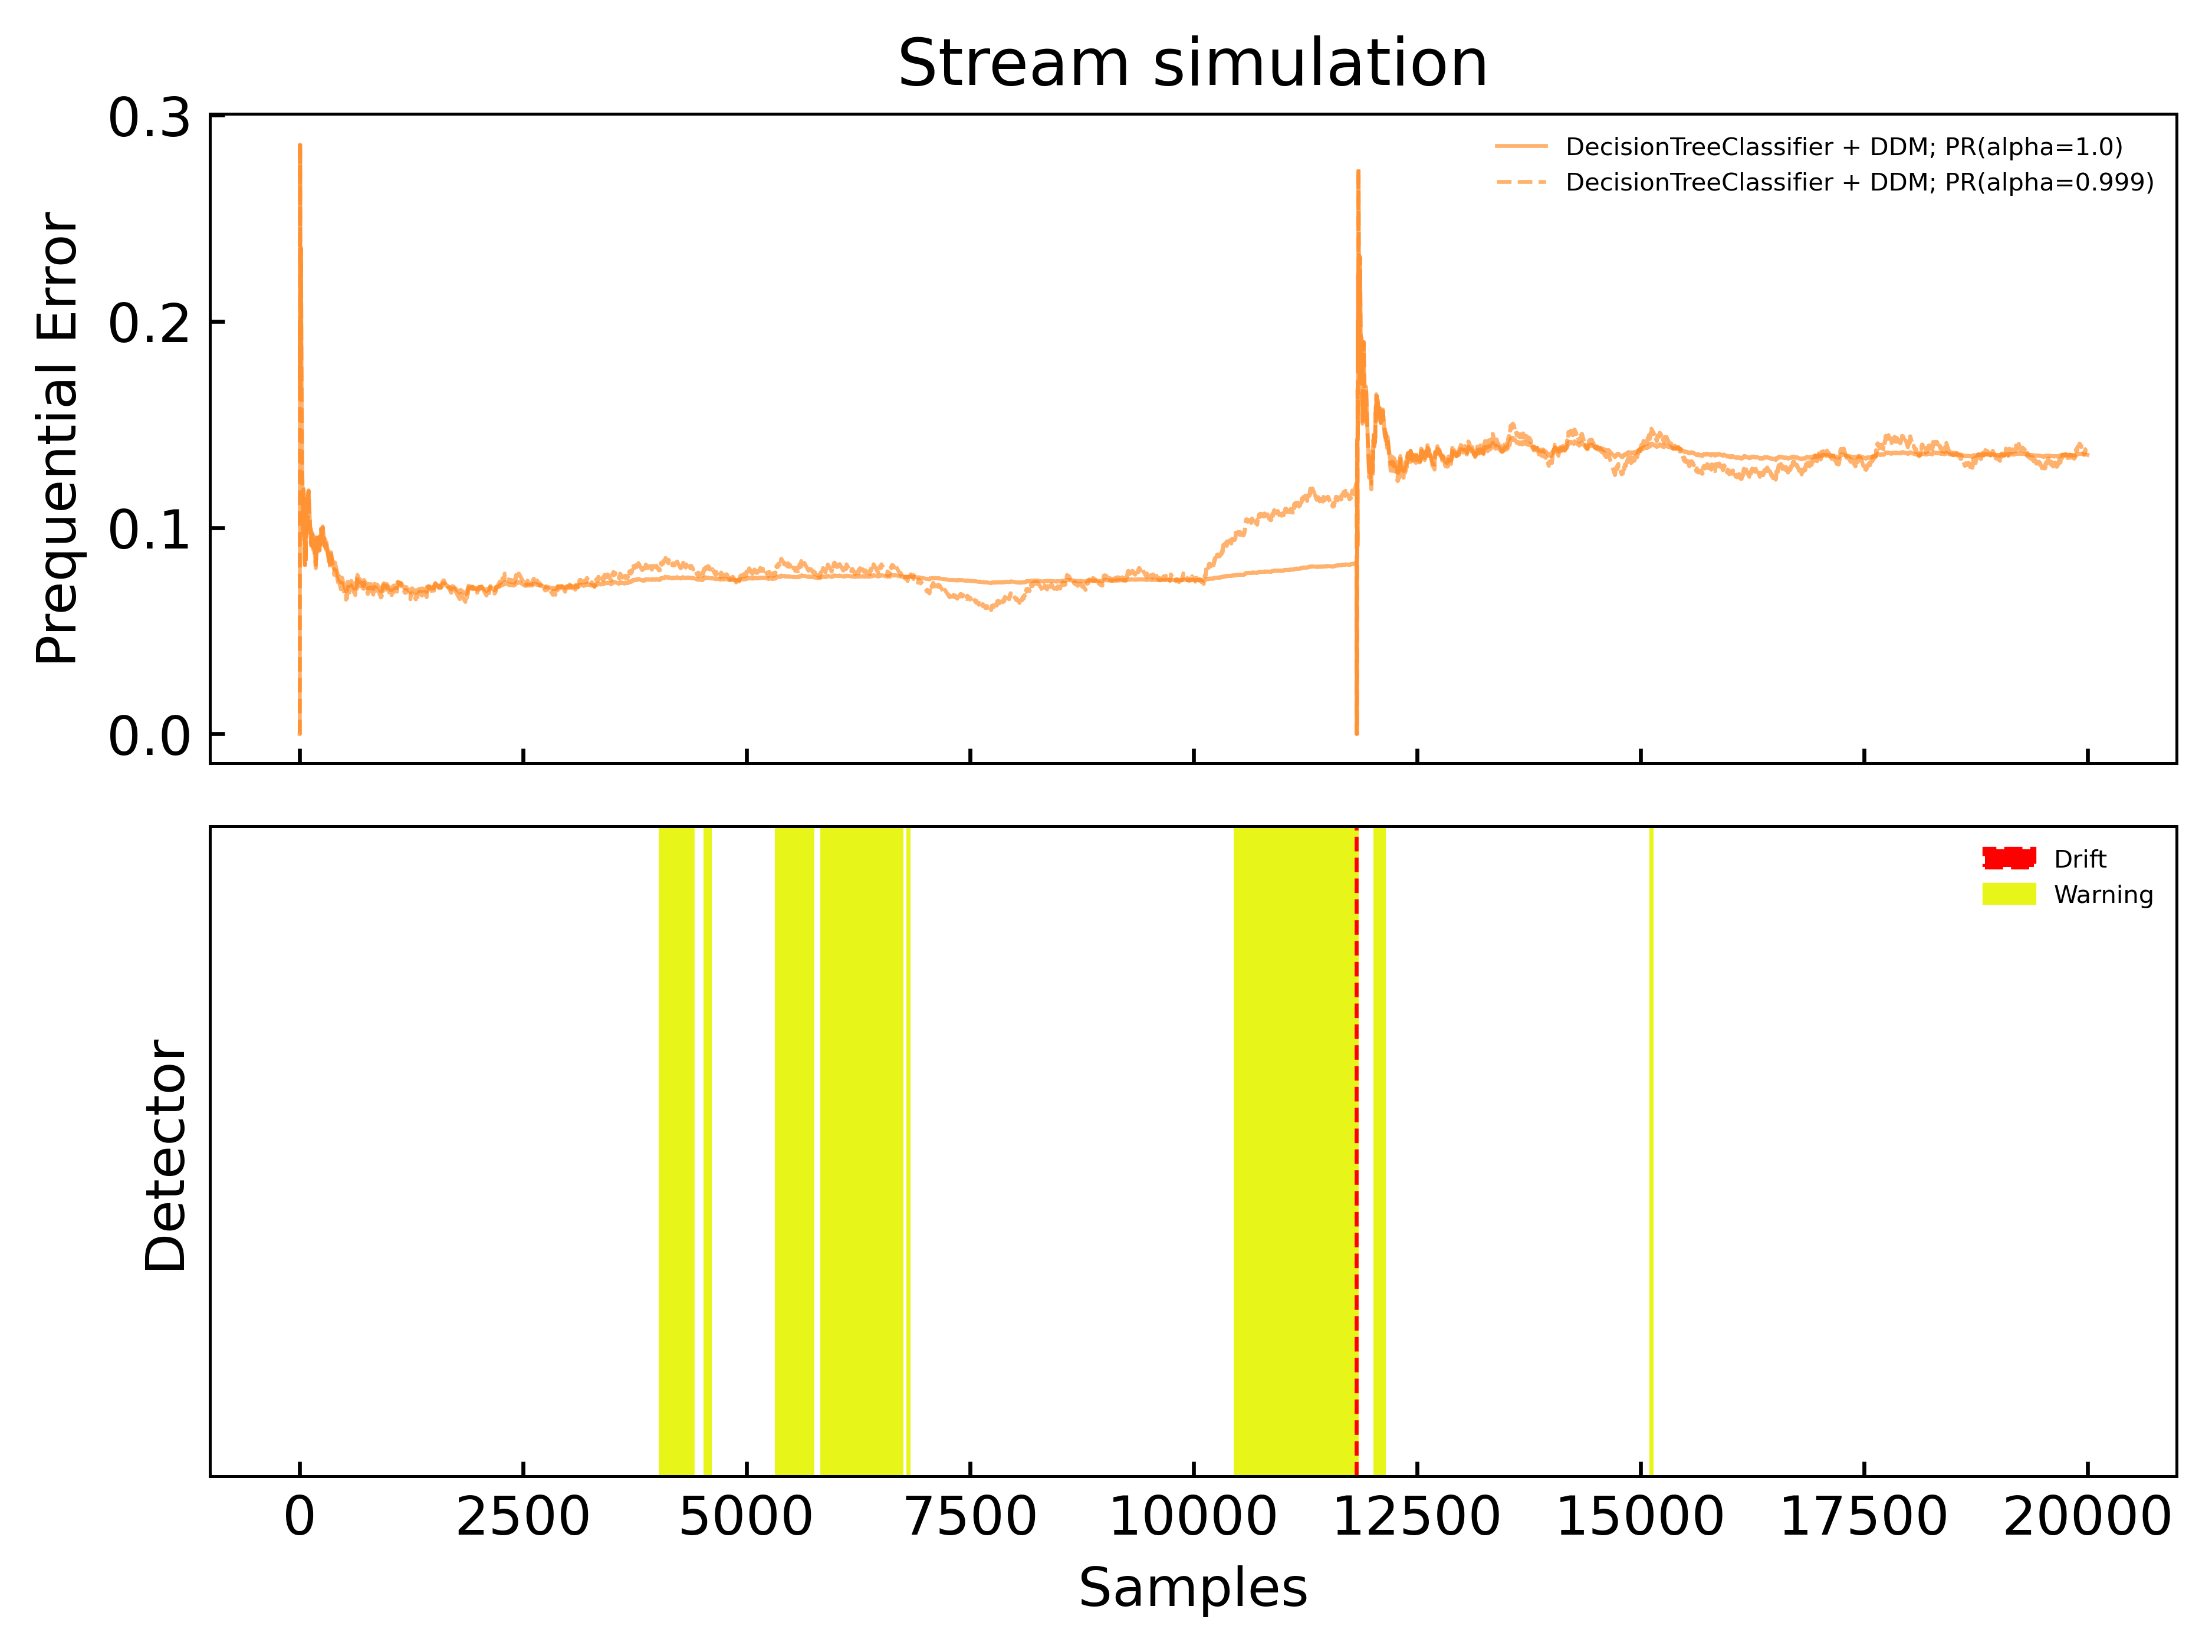

In [8]:
fsize = 11
tsize = 5
tdir = 'in'
major = 3.0
minor = 1.5
lwidth = 0.6
lhandle = 2.0

plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

lines = ["-", "--"]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=600)

alpha = 0.6
linewidth = 0.8

for (metric_name, metric_values), line in zip(metrics_historic_detector.items(), lines):
    ax[0].plot(metric_values,
               color="#ff7f0e",
               linestyle=line,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=linewidth)

ax[0].title.set_text("Stream simulation")
ax[0].set_ylabel("Prequential Error")
ax[0].legend(frameon=False)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
ax[1].legend(handles=[drift_path, warning_path], frameon=False)
plt.xlabel("Samples")
plt.tight_layout()
plt.show()